## Preprocessed Dataset for training

# 1. DeepFM
# 2. Neural FM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from deepctr.models import *
import deepctr
import csv

In [2]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, DenseFeat, get_feature_names

In [3]:
df= pd.read_csv('final_dataframe2.csv')
df.head(2) 

,Unnamed: 0,user_id,rating,recipe_id,recipe_name,tags_list,cooking_words,review_nums,aver_rate,category,year,month,day,hour
0,0,39,4,61727,Ten Minute Enchilada Sauce,15-minutes-or-less|north-american|sauces|condi...,powder|flour|chili|salt|oil|skillet|reduce|coo...,2443,4.439774,main-dish,2001,3,26,7
1,1,8799,5,61727,Ten Minute Enchilada Sauce,15-minutes-or-less|north-american|sauces|condi...,powder|flour|chili|salt|oil|skillet|reduce|coo...,2443,4.439774,main-dish,2004,9,21,6


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151148 entries, 0 to 151147
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     151148 non-null  int64  
 1   user_id        151148 non-null  int64  
 2   rating         151148 non-null  int64  
 3   recipe_id      151148 non-null  int64  
 4   recipe_name    151148 non-null  object 
 5   tags_list      151120 non-null  object 
 6   cooking_words  151145 non-null  object 
 7   review_nums    151148 non-null  int64  
 8   aver_rate      151148 non-null  float64
 9   category       151148 non-null  object 
 10  year           151148 non-null  int64  
 11  month          151148 non-null  int64  
 12  day            151148 non-null  int64  
 13  hour           151148 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 16.1+ MB


## Learning VarLenSparseFeat 



.__hash__()

In [5]:
# class VarLenSparseFeat(namedtuple('VarLenFeat',
#                                   ['name', 'maxlen', 'vocabulary_size', 'embedding_dim', 'combiner', 'use_hash',
#                                    'dtype','length_name' ,'weight_name', 'embedding_name', 'group_name'])):
#     __slots__ = ()

#     def __new__(cls, name, maxlen, vocabulary_size, embedding_dim=4, combiner="mean", use_hash=False, dtype="float32",
#                 length_name=None, weight_name=None, embedding_name=None, group_name=DEFAULT_GROUP_NAME):
#         if embedding_name is None:
#             embedding_name = name
#         if embedding_dim == "auto":
#             embedding_dim =  6 * int(pow(vocabulary_size, 0.25))
#         return super(VarLenSparseFeat, cls).__new__(cls, name, maxlen, vocabulary_size, embedding_dim, combiner,
#                                                     use_hash, dtype, length_name,weight_name, embedding_name, group_name)

#     def __hash__(self):
#         return self.name.__hash__()

In [6]:
df['review_nums'].nunique() 

1224

## Generating Sparse, Dense and Variable Length Features

In [7]:
# sparse and dense features 
sparse_features = ['recipe_name', 'category', 'user_id', 'month', 'day', 'hour']
dense_features = ['review_nums', 'rating']

# for columns with multiple values in the same row 
var_length_features = ['tags_list', 'cooking_words']

# the target column is the average rating of each recipe 
target = ['aver_rate']

In [8]:
# 1. Label Encoding: storing the label encoders for output comparison
label_encoders = {}
for feature in sparse_features:
  lbe = LabelEncoder()
  df[feature] = lbe.fit_transform(df[feature])
  label_encoders[feature] = lbe

In [9]:
# 2. Standard Scaling for Numerical Features
scalers = {}
for feature in dense_features:
  scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
  df[feature] = scaler.fit_transform(df[feature].values.reshape(-1,1))
  scalers[feature] = scaler

In [10]:
# key2index is used as global variable, instead of local
# hence, it is defined before this function is called

def split(x):
    key_ans = str(x).split('|')
    for key in key_ans:
        if key not in key2index:
            # input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [11]:
# 3. For var_length_features with variable length values
var_features = {} 
var_features_list = {}
var_features_lengths = {}
max_len_features = {}
features_list = {} 

# for the vocabulary size for SparseFeat inside VarLenSparseFeat
feature_key2index = {}

for feature in var_length_features:
    key2index={}
    var_features_list[feature] = list(map(split, df[feature].values))
    feature_key2index[feature] = key2index
    var_features_lengths[feature] = np.array(list(map(len, var_features_list[feature])))
    max_len_features[feature] = max(var_features_lengths[feature])
    
    # this can be important for the inference of the model
    features_list[feature] = pad_sequences(var_features_list[feature], maxlen=max_len_features[feature], padding='post', dtype='object', value=0).astype(int)


In [12]:
features_list

{'tags_list': array([[ 1,  2,  3, ...,  0,  0,  0],
        [ 1,  2,  3, ...,  0,  0,  0],
        [ 1,  2,  3, ...,  0,  0,  0],
        ...,
        [24, 26, 17, ...,  0,  0,  0],
        [23, 72, 43, ...,  0,  0,  0],
        [51, 15, 16, ...,  0,  0,  0]]),
 'cooking_words': array([[   1,    2,    3, ...,    0,    0,    0],
        [   1,    2,    3, ...,    0,    0,    0],
        [   1,    2,    3, ...,    0,    0,    0],
        ...,
        [  61,  204, 3936, ...,    0,    0,    0],
        [ 317,    1,  164, ...,    0,    0,    0],
        [  66,   31,  218, ...,    0,    0,    0]])}

In [13]:
var_features_list

{'tags_list': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [1, 2, 3, 4, 5, 

In [14]:
max_len_features

{'tags_list': 50, 'cooking_words': 50}

In [15]:
var_features_lengths

{'tags_list': array([14, 14, 14, ..., 19, 14, 20]),
 'cooking_words': array([24, 24, 24, ..., 36, 24, 36])}

In [16]:
features_list['tags_list'][0], len(features_list['tags_list'][0])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 50)

In [17]:
features_list['cooking_words'][1000], len(features_list['cooking_words'][1000])

(array([ 93,  98,  29, 126,  39,  41,   9, 127,  19,  27,  42, 128, 101,
        129,   2, 130,   4, 131, 113,  46,  25, 132, 133, 134,  49,  50,
        135, 136, 137, 138,  53, 124, 139,  99, 140,  57,  58,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 50)

In [49]:
df.head(2)

,Unnamed: 0,user_id,rating,recipe_id,recipe_name,tags_list,cooking_words,review_nums,aver_rate,category,year,month,day,hour
0,0,0,0.0,61727,6664,15-minutes-or-less|north-american|sauces|condi...,powder|flour|chili|salt|oil|skillet|reduce|coo...,0.112216,4.439774,2,2001,2,25,7
1,1,6,1.0,61727,6664,15-minutes-or-less|north-american|sauces|condi...,powder|flour|chili|salt|oil|skillet|reduce|coo...,0.112216,4.439774,2,2004,8,20,6


## Dataset Preparation for Model 

In [63]:
# # fixed length feature columns 
fixlen_feature_columns = [SparseFeat(feature, vocabulary_size=df[feature].nunique() * 5, embedding_dim=4, use_hash=True)
                          for feature in sparse_features] + [
                              DenseFeat(feature, 1) for feature in dense_features
                          ] + [
                              VarLenSparseFeat(
                                  SparseFeat(feature, vocabulary_size=len(feature_key2index[feature]) + 1, embedding_dim=4, dtype='int32'),
                                  maxlen=max_len_features[feature],
                                  combiner="mean",
                                  weight_name=None
                              )
                            for feature in var_length_features
                          ]

# string to int error aborted by omitting 'dtype' parameter in SparseFeat
# fixlen_feature_columns = [SparseFeat(feature, vocabulary_size=df[feature].max() + 1, embedding_dim=4, use_hash=True)
#                           for feature in sparse_features] + [
#                               DenseFeat(feature, 1) for feature in dense_features
#                           ] 

In [64]:
fixlen_feature_columns

[SparseFeat(name='recipe_name', vocabulary_size=36400, embedding_dim=4, use_hash=True, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000229AAC3B0C8>, embedding_name='recipe_name', group_name='default_group', trainable=True),
 SparseFeat(name='category', vocabulary_size=15, embedding_dim=4, use_hash=True, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x0000022983ACA988>, embedding_name='category', group_name='default_group', trainable=True),
 SparseFeat(name='user_id', vocabulary_size=7875, embedding_dim=4, use_hash=True, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000229B7E87D88>, embedding_name='user_id', group_name='default_group', trainable=True),
 SparseFeat(name='month', vocabulary_size=60, embedding_di

In [65]:
linear_feature_columns = fixlen_feature_columns 
dnn_feature_columns = fixlen_feature_columns 
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
feature_names

['recipe_name',
 'category',
 'user_id',
 'month',
 'day',
 'hour',
 'review_nums',
 'rating',
 'tags_list',
 'cooking_words']

In [66]:
features_list[feature]

array([[   1,    2,    3, ...,    0,    0,    0],
       [   1,    2,    3, ...,    0,    0,    0],
       [   1,    2,    3, ...,    0,    0,    0],
       ...,
       [  61,  204, 3936, ...,    0,    0,    0],
       [ 317,    1,  164, ...,    0,    0,    0],
       [  66,   31,  218, ...,    0,    0,    0]])

In [67]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [68]:
train_model_input = {name: train[name] for name in feature_names}
for feature in var_length_features:
    train_model_input[feature] = features_list[feature]
    train_model_input[feature+"_weight"] = np.random.randn(train.shape[0], max_len_features[feature], 1)
    
test_model_input = {name: test[name] for name in feature_names}
train_model_input[feature+"_weight"].shape 

(120918, 50, 1)

In [69]:
train.shape, test.shape, len(train_model_input['tags_list'])

((120918, 14), (30230, 14), 151148)

In [70]:
for l in list(train_model_input.keys()):
    print(train_model_input[l].dtype)  

int32
int32
int64
int64
int64
int64
float64
float64
int32
int32
float64
float64


In [71]:
train[target].info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120918 entries, 118541 to 112227
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   aver_rate  120918 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [72]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=30, verbose=1, validation_split=0.2, )

Epoch 1/30


c:\Users\OMEN\anaconda3\envs\deepctr\lib\site-packages\tensorflow\python\keras\engine\functional.py:590: UserWarning: Input dict contained keys ['tags_list_weight', 'cooking_words_weight'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


378/378 [==============================] - 7s 12ms/step - loss: 0.9779 - mse: 0.9778 - val_loss: 0.0066 - val_mse: 0.0064
Epoch 2/30
378/378 [==============================] - 4s 10ms/step - loss: 0.0044 - mse: 0.0042 - val_loss: 0.0050 - val_mse: 0.0049
Epoch 3/30
378/378 [==============================] - 4s 11ms/step - loss: 0.0033 - mse: 0.0031 - val_loss: 0.0049 - val_mse: 0.0047
Epoch 4/30
378/378 [==============================] - 4s 10ms/step - loss: 0.0030 - mse: 0.0028 - val_loss: 0.0048 - val_mse: 0.0046
Epoch 5/30
378/378 [==============================] - 4s 11ms/step - loss: 0.0029 - mse: 0.0026 - val_loss: 0.0048 - val_mse: 0.0046
Epoch 6/30
378/378 [==============================] - 3s 9ms/step - loss: 0.0028 - mse: 0.0025 - val_loss: 0.0047 - val_mse: 0.0045
Epoch 7/30
378/378 [==============================] - 4s 11ms/step - loss: 0.0027 - mse: 0.0025 - val_loss: 0.0047 - val_mse: 0.0044
Epoch 8/30
378/378 [==============================] - 4s 11ms/step - loss: 0.0026

In [73]:
loss = history.history['loss']
val_loss = history.history['val_loss']

c:\Users\OMEN\anaconda3\envs\deepctr\lib\site-packages\ipykernel_launcher.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  import sys
c:\Users\OMEN\anaconda3\envs\deepctr\lib\site-packages\ipykernel_launcher.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  


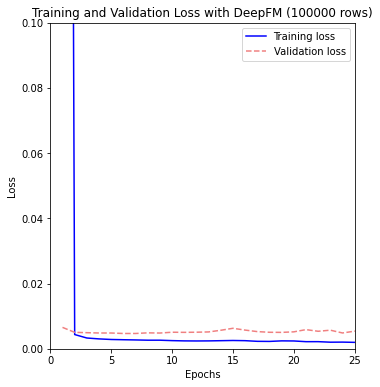

In [77]:
epoch_arr = list(range(1, 30+1))

# Plotting the Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_arr, loss, 'b-', label='Training loss', color='blue')
plt.plot(epoch_arr, val_loss, 'r--', label='Validation loss', color='lightcoral')
plt.title('Training and Validation Loss with DeepFM (100000 rows)')
ax = plt.gca()
ax.set_xlim([0,25])
ax.set_ylim([0, 0.1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

c:\Users\OMEN\anaconda3\envs\deepctr\lib\site-packages\ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
c:\Users\OMEN\anaconda3\envs\deepctr\lib\site-packages\ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  if sys.path[0] == '':


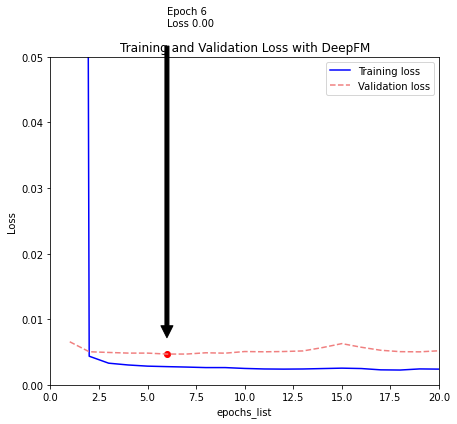

In [79]:
epochs_list = list(range(1, 31))

#getting lowest val_loss
min_loss_epoch = epochs_list[val_loss.index(min(val_loss))]
min_loss_value = min(val_loss)

# Plotting the Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, loss, 'b-', label='Training loss', color='blue')
plt.plot(epochs_list, val_loss, 'r--', label='Validation loss', color='lightcoral')
plt.scatter(min_loss_epoch, min_loss_value, color='red')  # Red dot at minimum validation loss
plt.annotate(f'Epoch {min_loss_epoch}\nLoss {min_loss_value:.2f}',
             xy=(min_loss_epoch, min_loss_value),
             xytext=(min_loss_epoch, min_loss_value + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Training and Validation Loss with DeepFM')
ax = plt.gca()
ax.set_xlim([0,20])
ax.set_ylim([0,0.05])
plt.xlabel('epochs_list')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [80]:
train_model_input.keys()

dict_keys(['recipe_name', 'category', 'user_id', 'month', 'day', 'hour', 'review_nums', 'rating', 'tags_list', 'cooking_words', 'tags_list_weight', 'cooking_words_weight'])